# Вариант 2-05

In [47]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from scipy import interp

from utils import table, load_styles, heatmap, printf
load_styles()

In [52]:
pylab.rcParams['figure.figsize'] = (24.0, 16.0)
plt.rcParams.update({'font.size': 22})

n=500, M=2, K=4


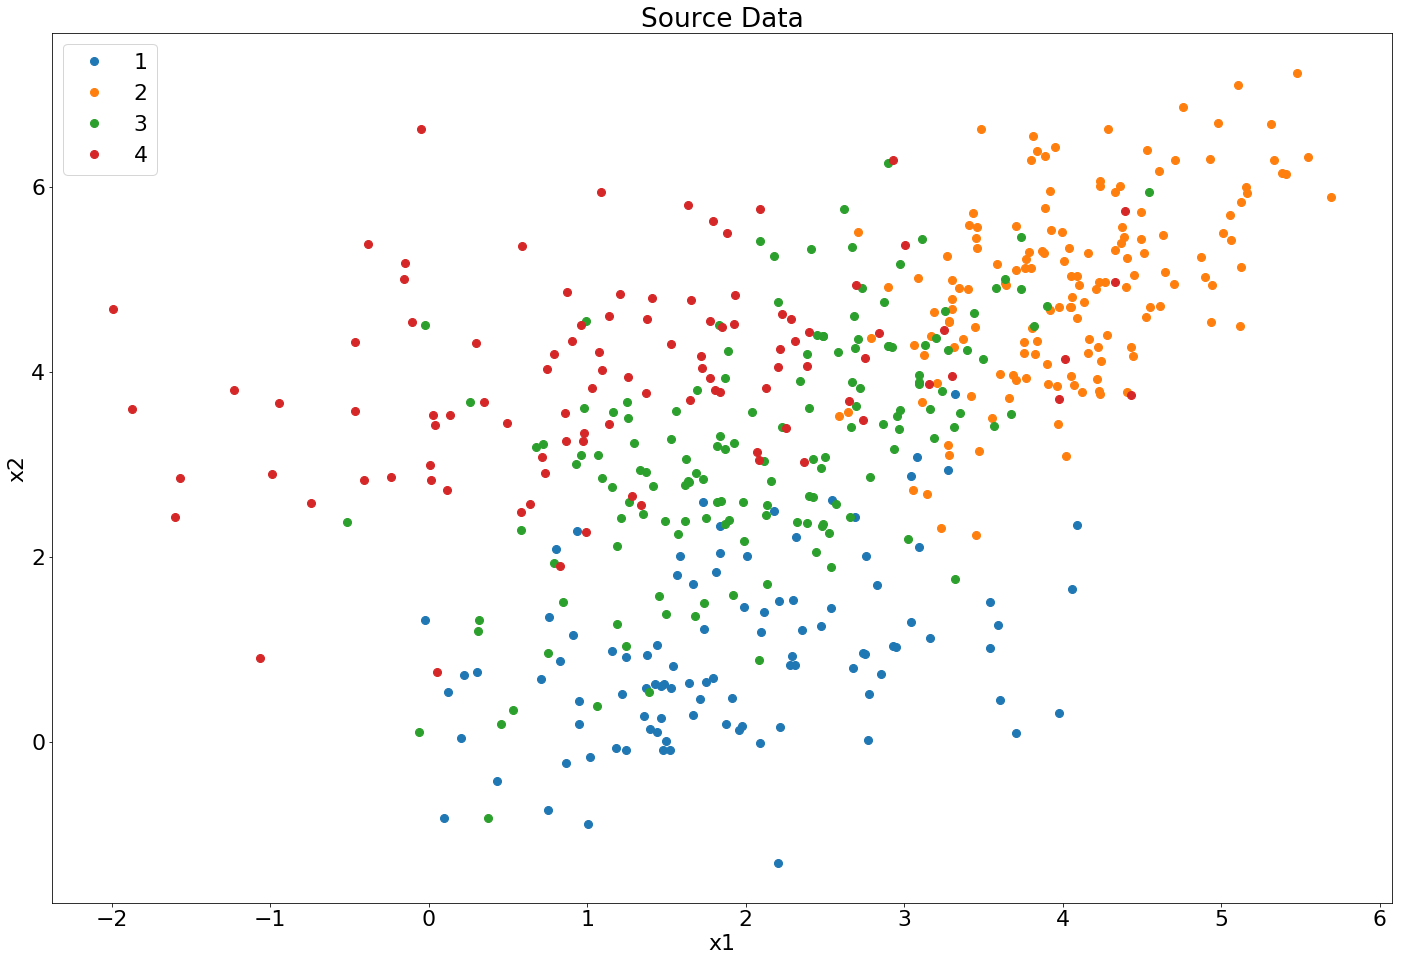

In [12]:
data = pd.read_csv('data.csv', dtype={
    'x1': np.float64,
    'x2': np.float64,
    'label': str
})
sample = data.values
x1    = list(sample[:, 0])
x2    = list(sample[:, 1])
klass = list(sample[:, 2])

x1_train, x1_test, x2_train, x2_test, klass_train, klass_test = train_test_split(
    x1, x2, klass, test_size=0.3, random_state=42
)

class_labels = np.unique(klass)

M = 2
K = len(class_labels)
n = len(x1)

def split_data(x1, x2, klass):
    split = {}
    for label in class_labels:
        split[label] = { 'x1': [], 'x2': [], 'len': 0 }

    for i in range(len(klass)):
        klass_i = klass[i]
        x1_i = x1[i]
        x2_i = x2[i]
        split[klass_i]['x1'].append(x1_i)
        split[klass_i]['x2'].append(x2_i)

    for label in class_labels:
        split[label]['len'] = len(split[label]['x1'])
        split[label]['cov'] = np.cov([split[label]['x1'], split[label]['x2']])
        
    return split

split = split_data(x1, x2, klass)
split_train = split_data(x1_train, x2_train, klass_train)
split_test = split_data(x1_test, x2_test, klass_test)

fig, ax = plt.subplots()
ax.set_title('Source Data')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

for label in class_labels:
    plt.plot(split[label]['x1'], split[label]['x2'], 'o', markersize=8, label=label)
    
plt.legend()

print('n={n}, M={M}, K={K}'.format(n=n, M=M, K=K))

## 1. Ковариационные матрицы

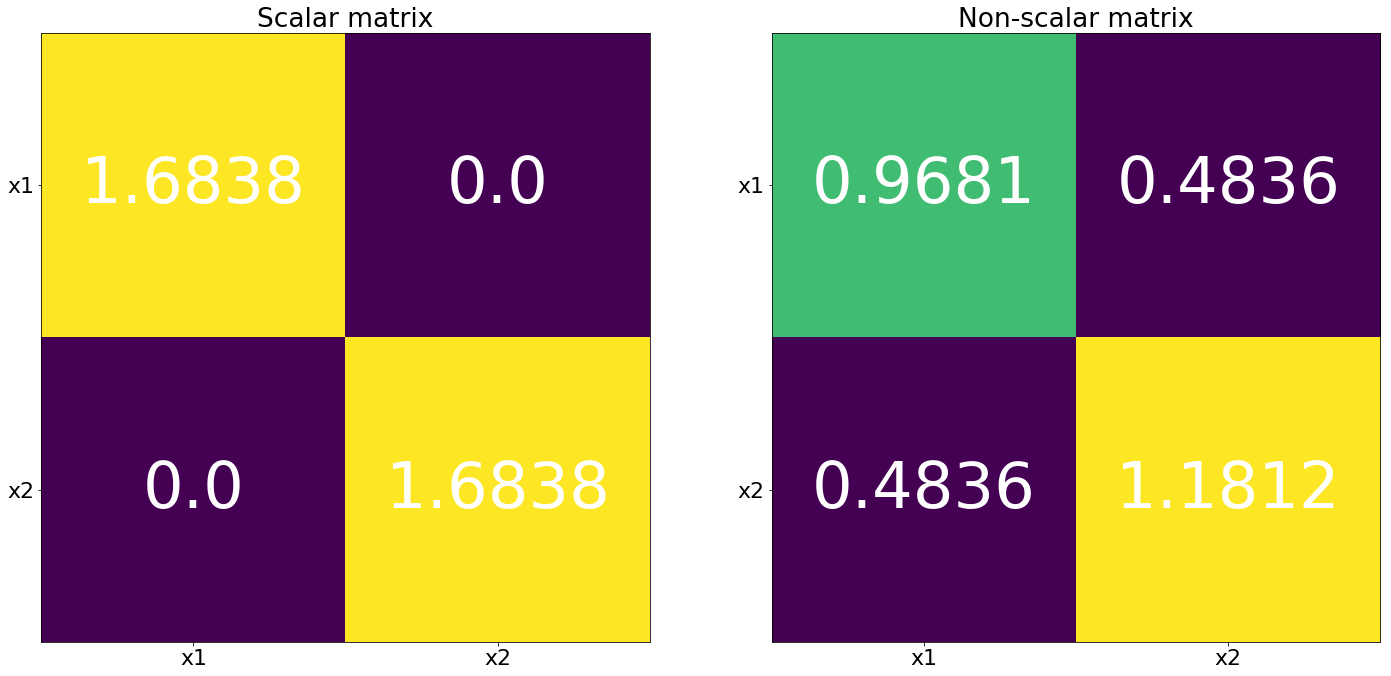

In [13]:
printf('<h2 class="text-center">Same matrices</h2>')

fig, ax = plt.subplots(1, 2)

I = np.identity(2)
sigma = np.std(np.concatenate([x1, x2]), ddof=1)

scalar_cov = I * sigma

heatmap(
    np.around(scalar_cov, 4),
    canvas=ax[0],
    title='Scalar matrix',
    xlabels=['x1', 'x2'],
    ylabels=['x1', 'x2'],
    digit_size=64
)


def pooled_cov(ddof=1):
    ns = np.array([split[label]['len'] for label in class_labels])
    sum_ns = np.sum(ns - ddof)
    covs = np.array([split[label]['cov'] for label in class_labels])
    
    weighted_sum = np.sum([ns[i] * covs[i] for i in range(len(ns))], axis=0)
    
    return 1. / sum_ns * weighted_sum

shared_cov = pooled_cov()

heatmap(
    np.around(shared_cov, 4),
    canvas=ax[1],
    title='Non-scalar matrix',
    xlabels=['x1', 'x2'],
    ylabels=['x1', 'x2'],
    digit_size=64
)

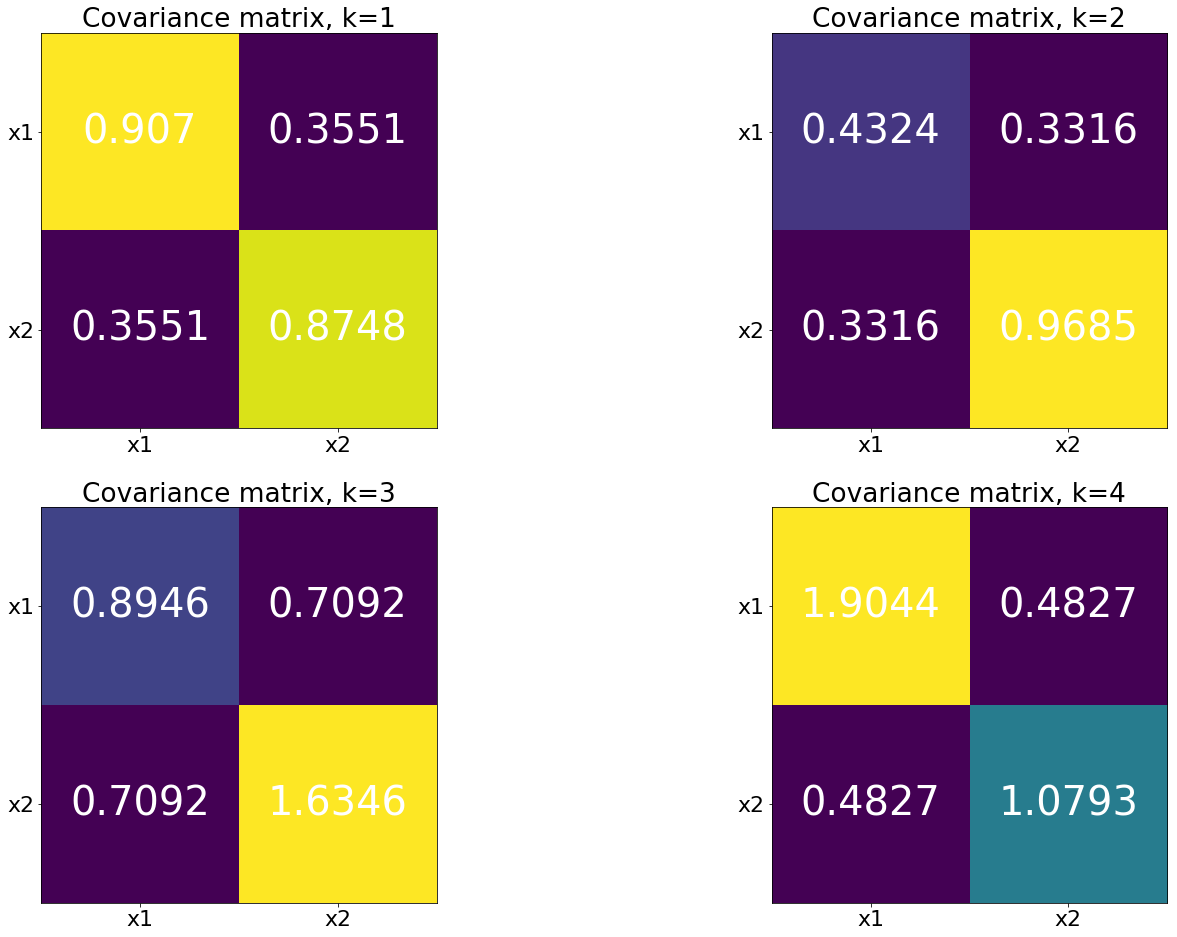

In [14]:
printf('<h2 class="text-center">Different matrices</h2>')

fig, ax = plt.subplots(2, 2)
subplots = [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]

for i in range(K):
    label = class_labels[i]
    canvas = subplots[i]

    heatmap(
        np.around(split[label]['cov'], 4),
        xlabels=['x1', 'x2'],
        ylabels=['x1', 'x2'],
        canvas=canvas,
        title='Covariance matrix, k={}'.format(label),
        digit_size=40
    )

## Создание и обучение регуляризированного Байесовского классификатора

In [15]:
def dot(*matrices):
    result = matrices[0]
    for next_matrix in matrices[1:]:
        result = np.dot(result, next_matrix)
    return result

def train_bayes(split, alpha=0, beta=0):
    def cov_matrix(label):
        return alpha * scalar_cov + beta * shared_cov + (1 - alpha - beta) * split[label]['cov']
    
    covs = {}
    means = {}
    for label in class_labels:
        covs[label] = cov_matrix(label)
        means[label] = np.array([
            np.mean(split[label]['x1']),
            np.mean(split[label]['x2'])
        ])
        
    def logd(label, x):
        inv_cov_k = np.linalg.inv(covs[label])
        mean_k = means[label]
        
        p_k = 1. / K  # aprior probs are considered to be equal, according to task
        
        A_k = -0.5 * inv_cov_k
        b_k = dot(inv_cov_k, mean_k)
        c_k = -0.5 * dot(mean_k.T, inv_cov_k, mean_k) - 0.5 * np.log(np.linalg.det(covs[label])) + np.log(p_k)
        
        result = dot(x.T, A_k, x) + dot(b_k.T, x) + c_k
#         print(b_k.T.shape)
#         print(x.shape)
        return result
    
    def predict(x, score=False):
        scores = [logd(label, x) for label in class_labels]
        winner = np.argmax(scores)
#         print(scores)
#         print(winner)
        if winner >= 4:
            print('wtf')
            print(winner)
            print(scores[0].shape)
            print(alpha, beta)
        if score:
            return scores[winner]
        else:
            return class_labels[winner]
        
    
    return { 'predict': predict, 'logd': logd }

## 2. Матрицы точности классификаторов

In [16]:
def correctness_matrix(predict, split):
    result = np.zeros((K, K))
    for true_label in split:
        x1 = split[true_label]['x1']
        x2 = split[true_label]['x2']
        true_label_i = np.where(class_labels==true_label)[0][0]
        
        for i in range(len(x1)):
            x1_i = x1[i]
            x2_i = x2[i]
            predicted_label = predict(np.array([x1_i, x2_i]))
            predicted_label_i = np.where(class_labels==predicted_label)[0][0]
            result[predicted_label_i][true_label_i] += 1
        
    return result

def true_positives(matrix, k):
    return matrix[k][k]

def true_negatives(matrix, k):
    result = 0
    for i in range(K):
        for j in range(K):
            if i == k:
                continue
            if j == k:
                continue
            result += matrix[i][j]
            
    return result

def accuracy(matrix):
    n = np.sum(matrix)
    
    TP_sum = 0
    TN_sum = 0
    for k in range(K):
        TP_sum += true_positives(matrix, k)
        TN_sum += true_negatives(matrix, k)
        
    return (TP_sum + TN_sum) * 1. / K / n
        

In [48]:
def loop_albeta(f, n=10):
    alphas = np.linspace(0, 1, n)
    betas = np.linspace(0, 1, n)
    
    for a in range(n):
        for b in range(n):
            alpha = alphas[a]
            beta = betas[b]
            f(alpha=alpha, beta=beta, a=a, b=b)

def mk_accuracy_matrix(train, split, n=10):
    result = np.zeros((n, n))
    
    def loop_body(alpha, beta, a, b):
        bayes = train_bayes(train, alpha=alpha, beta=beta)
        predict = bayes['predict']
        cm = correctness_matrix(predict, split)
        acc = accuracy(cm)
        result[a][b] = acc
    
    loop_albeta(loop_body, n)
            
    return result

In [49]:
acc_matrix_size = 10
acc_matrix_train = mk_accuracy_matrix(split_train, split_train, acc_matrix_size)
acc_matrix_test  = mk_accuracy_matrix(split_train, split_test,  acc_matrix_size)

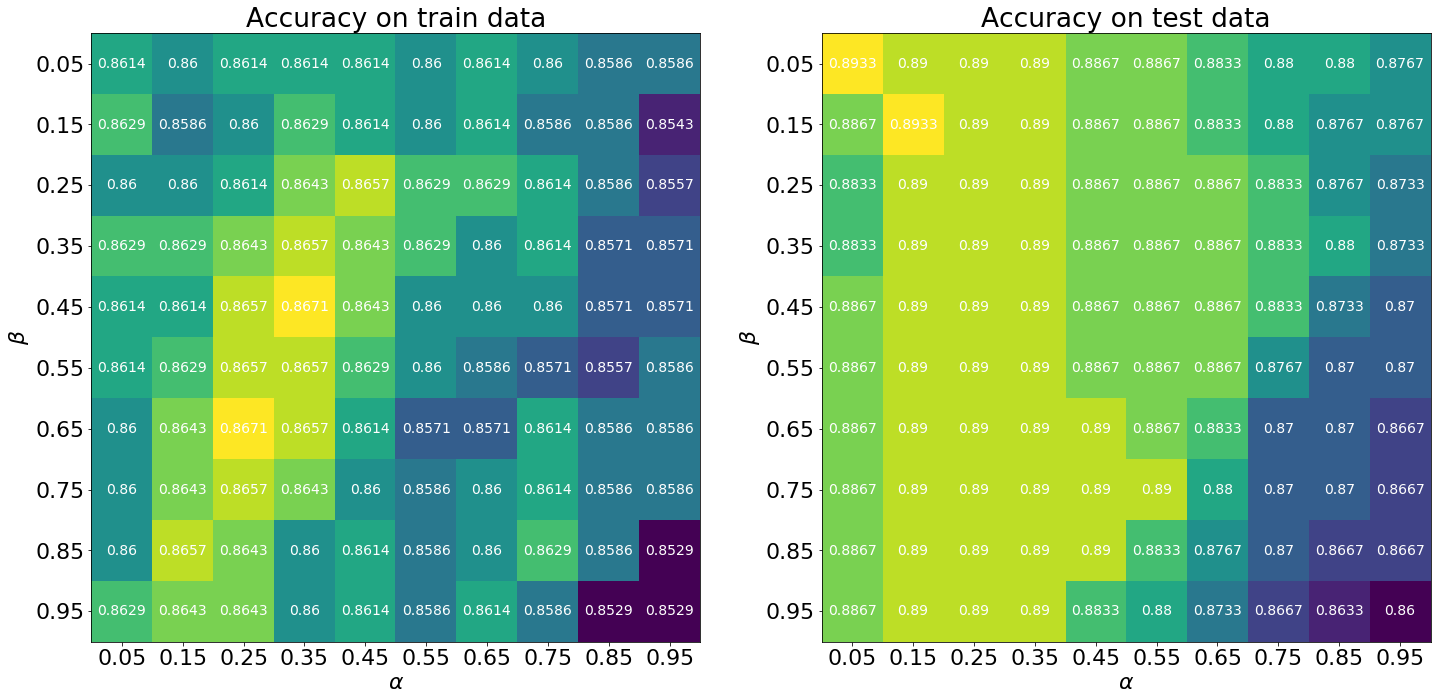

In [53]:
fig, ax = plt.subplots(1, 2)

heatmap(
    acc_matrix_train.T,
    canvas=ax[0],
    title='Accuracy on train data',
    xlabels=np.round(np.linspace(0.05, 0.95, acc_matrix_size), 2),
    ylabels=np.round(np.linspace(0.05, 0.95, acc_matrix_size), 2),
    digit_size=14
)
ax[0].set_xlabel('$\\alpha$')
ax[0].set_ylabel('$\\beta$')

heatmap(
    acc_matrix_test.T,
    canvas=ax[1],
    title='Accuracy on test data',
    xlabels=np.round(np.linspace(0.05, 0.95, acc_matrix_size), 2),
    ylabels=np.round(np.linspace(0.05, 0.95, acc_matrix_size), 2),
    digit_size=14
)
ax[1].set_xlabel('$\\alpha$')
ax[1].set_ylabel('$\\beta$')

plt.show()

## 3. Области классов

In [64]:
def calc_map(predict, precisions=[50, 50]):
    x1_space = np.linspace(min(x1), max(x1), precisions[0])
    x2_space = np.linspace(min(x2), max(x2), precisions[1])
    
    result = {}
    for label in class_labels:
        result[label] = { 'x1': [], 'x2': [] }
        
    for x1_i in x1_space:
        for x2_i in x2_space:
            point = np.array([x1_i, x2_i])
            label = predict(point)
            map_entry = result[label]
            map_entry['x1'].append(x1_i)
            map_entry['x2'].append(x2_i)
                
    return result


def draw_map(class_map, canvas, alpha=0.2, data_size=8):
    for label in class_labels:
        map_entry = class_map[label]
        x1, x2 = map_entry['x1'], map_entry['x2']
        drawn = canvas.plot(x1, x2, 'o', label=label + ' predicted', markersize=8, alpha=alpha)
        color = drawn[0].get_color()
        canvas.plot(split[label]['x1'], split[label]['x2'], 'o', color=color, markersize=data_size, label=label)


def get_albeta_from_matrix(matrix, mode='max'):
    if mode == 'max':
        a, b = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    else:
        a, b = np.unravel_index(np.argmin(matrix, axis=None), matrix.shape)
    w, h = matrix.shape
    alpha, beta = 1. * a / w, 1. * b / h
    return { 'alpha': alpha + 0.05, 'beta': beta + 0.05 }
        
parameters = [
    get_albeta_from_matrix(acc_matrix_train),
    get_albeta_from_matrix(acc_matrix_test),
    { 'alpha': 0, 'beta': 1 },
    { 'alpha': 1, 'beta': 0 },
    { 'alpha': 0, 'beta': 0 },
    { 'alpha': 0.5, 'beta': 0.5 }
]
        
maps = []
for i in range(6):
    params = parameters[i]
    classifier = train_bayes(split_train, **params)
    class_map = calc_map(classifier['predict'], precisions=[70, 50])
    maps.append(class_map)

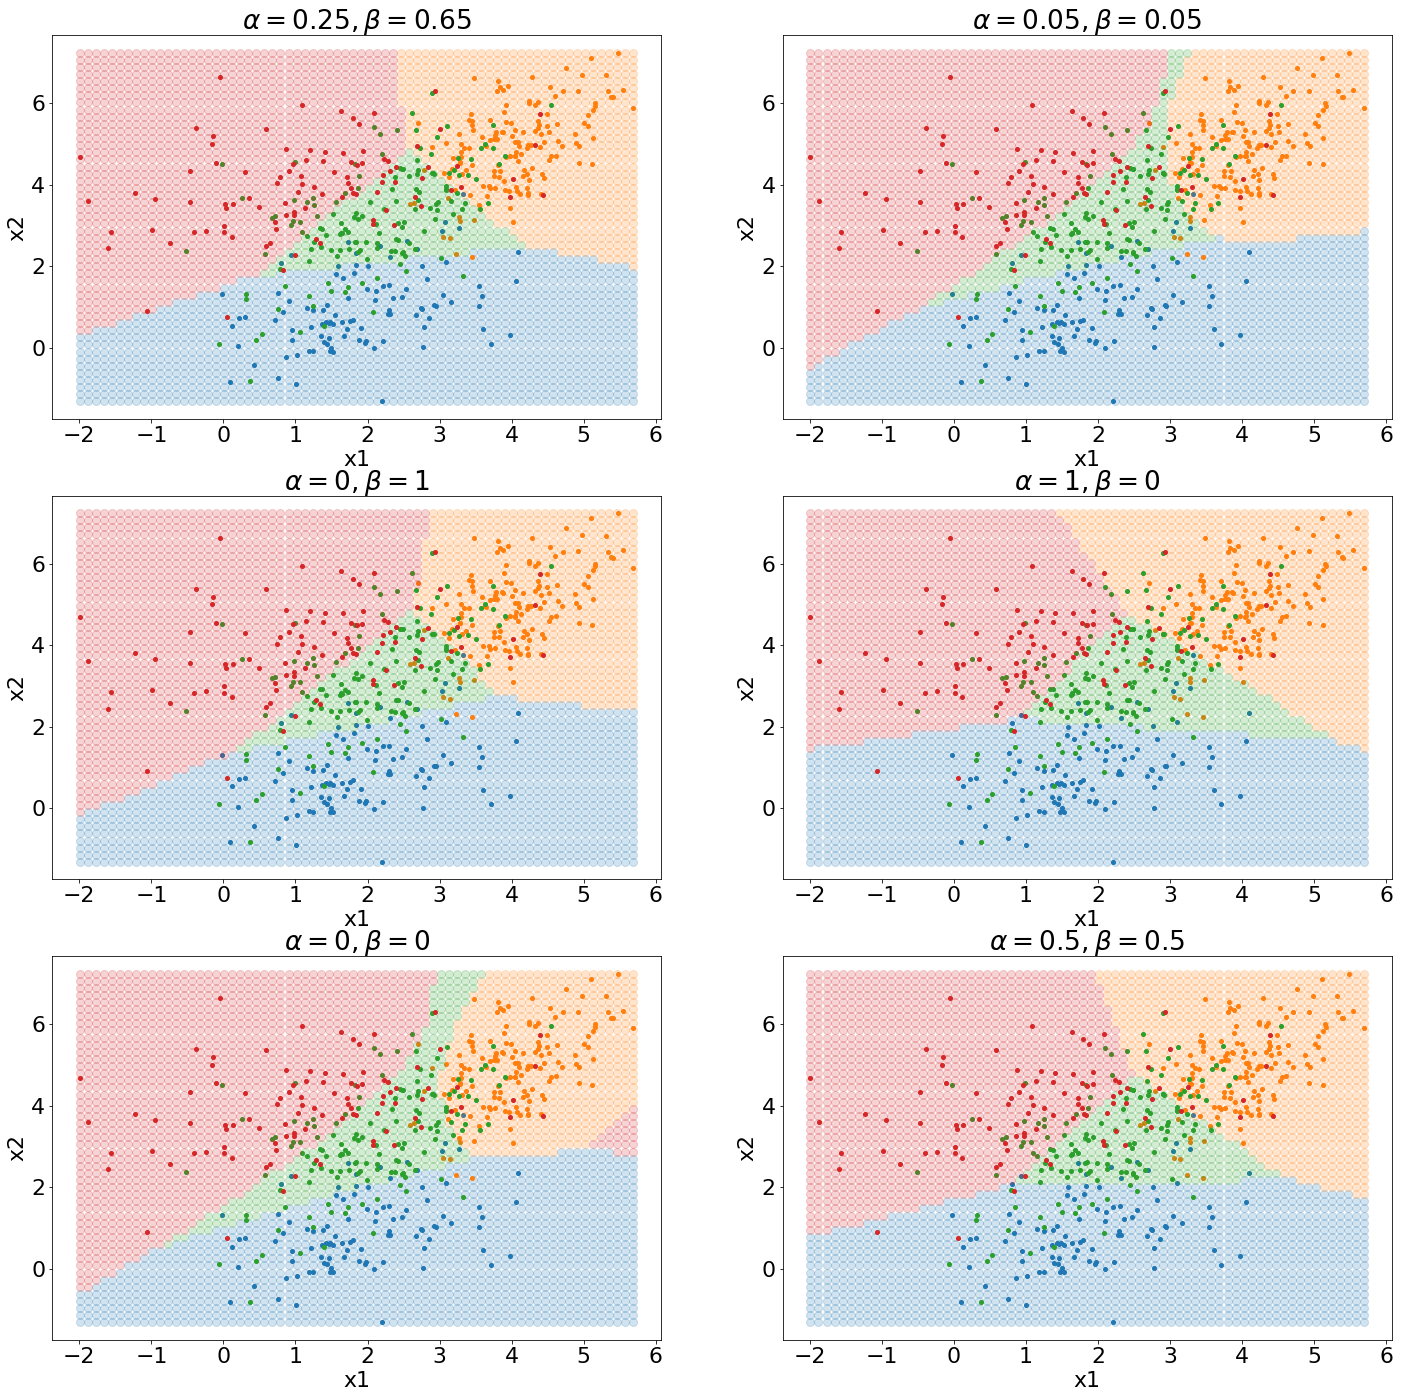

In [46]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(24, 24)

canvases = [ax[0][0], ax[0][1], ax[1][0], ax[1][1], ax[2][0], ax[2][1]]

for i in range(6):
    canvas = canvases[i]
    params = parameters[i]
    class_map = maps[i]
    draw_map(class_map, canvas, data_size=4)
    canvas.set_title('$\\alpha={alpha}, \\beta={beta}$'.format(**params))
    canvas.set_xlabel('x1')
    canvas.set_ylabel('x2')

plt.show();

## 4. Macro-averaged ROC AUC

In [58]:
def macro_roc(xs, y, predict):
    y_scores = np.array([predict(x, score=True) for x in xs])
    fprs = []
    tprs = []
    for label in class_labels:
        fpr, tpr, _ = roc_curve(y, y_scores, pos_label=label)
        fprs.append(fpr)
        tprs.append(tpr)
        
    all_fpr = np.unique(np.concatenate([fprs[i] for i in range(K)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(K):
        mean_tpr += interp(all_fpr, fprs[i], tprs[i])
        
    mean_tpr /= K
        
    macro_fpr = all_fpr
    macro_tpr = mean_tpr
    return macro_fpr, macro_tpr

def mk_auc_matrices(n=10):
    result_train = np.zeros((n, n))
    result_test  = np.zeros((n, n))
    
    xs_train = [np.array([x1_train[i], x2_train[i]]) for i in range(len(x1_train))]
    xs_test  = [np.array([x1_test [i], x2_test [i]]) for i in range(len(x1_test ))]
    
    def loop_body(alpha, beta, a, b):
        bayes = train_bayes(split_train, alpha=alpha, beta=beta)
        predict = bayes['predict']
        fpr, tpr = macro_roc(xs_train, klass_train, predict)
        auc_train = auc(fpr, tpr)
        
        fpr, tpr = macro_roc(xs_test, klass_test, predict)
        auc_test = auc(fpr, tpr)
        
        result_train[a][b] = auc_train
        result_test [a][b] = auc_test
        
    loop_albeta(loop_body, n)
        
    return result_train, result_test

In [59]:
auc_matrix_train, auc_matrix_test = mk_auc_matrices(acc_matrix_size)

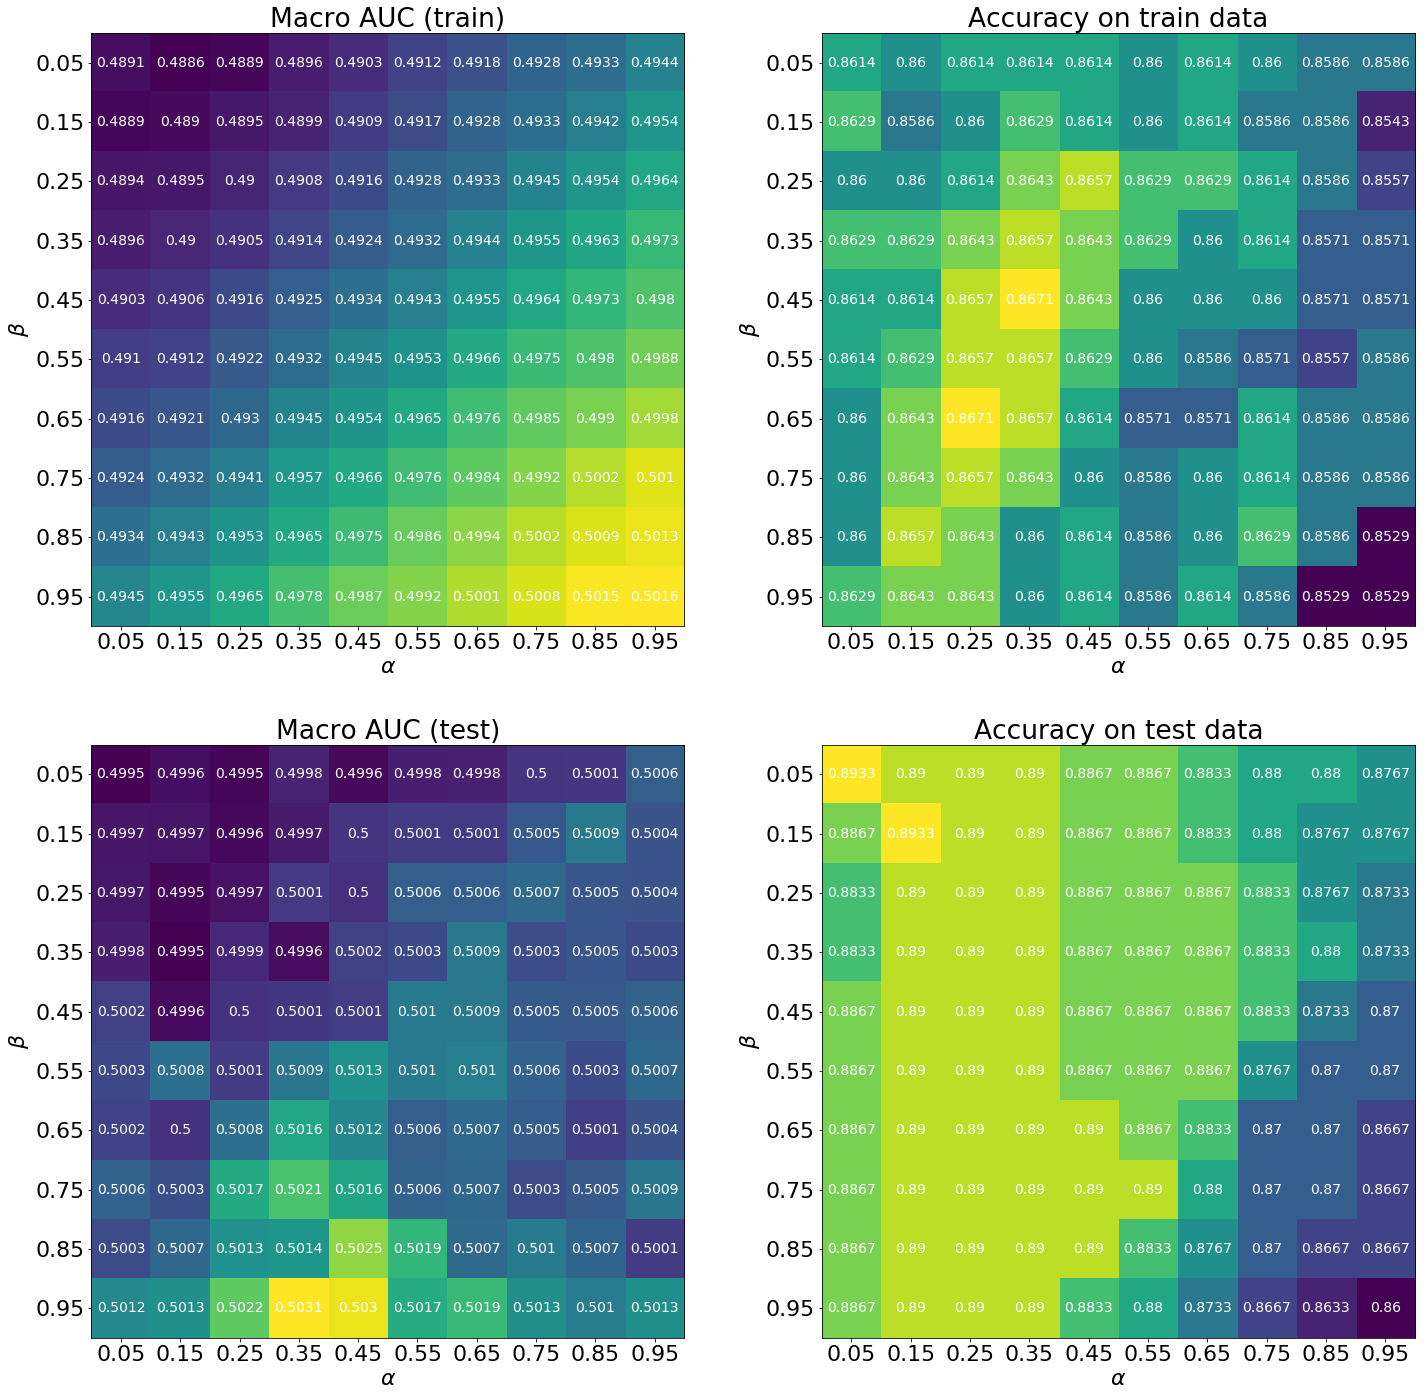

In [63]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(24, 24)

heatmap(
    auc_matrix_train.T,
    canvas=ax[0][0],
    title='Macro AUC (train)',
    xlabels=np.round(np.linspace(0.05, 0.95, acc_matrix_size), 2),
    ylabels=np.round(np.linspace(0.05, 0.95, acc_matrix_size), 2),
    digit_size=14
)
ax[0][0].set_xlabel('$\\alpha$')
ax[0][0].set_ylabel('$\\beta$')

heatmap(
    auc_matrix_test.T,
    canvas=ax[1][0],
    title='Macro AUC (test)',
    xlabels=np.round(np.linspace(0.05, 0.95, acc_matrix_size), 2),
    ylabels=np.round(np.linspace(0.05, 0.95, acc_matrix_size), 2),
    digit_size=14
)
ax[1][0].set_xlabel('$\\alpha$')
ax[1][0].set_ylabel('$\\beta$')

# accuracies
heatmap(
    acc_matrix_train.T,
    canvas=ax[0][1],
    title='Accuracy on train data',
    xlabels=np.round(np.linspace(0.05, 0.95, acc_matrix_size), 2),
    ylabels=np.round(np.linspace(0.05, 0.95, acc_matrix_size), 2),
    digit_size=14
)
ax[0][1].set_xlabel('$\\alpha$')
ax[0][1].set_ylabel('$\\beta$')

heatmap(
    acc_matrix_test.T,
    canvas=ax[1][1],
    title='Accuracy on test data',
    xlabels=np.round(np.linspace(0.05, 0.95, acc_matrix_size), 2),
    ylabels=np.round(np.linspace(0.05, 0.95, acc_matrix_size), 2),
    digit_size=14
)
ax[1][1].set_xlabel('$\\alpha$')
ax[1][1].set_ylabel('$\\beta$')

plt.show()

In [74]:
parameters = [
    get_albeta_from_matrix(auc_matrix_train, mode='min'),
    get_albeta_from_matrix(auc_matrix_test, mode='min')
]

for p in parameters:
    for key in p:
        p[key] = round(p[key], 4)

maps = []
for i in range(len(parameters)):
    params = parameters[i]
    classifier = train_bayes(split_train, **params)
    class_map = calc_map(classifier['predict'], precisions=[70, 50])
    maps.append(class_map)

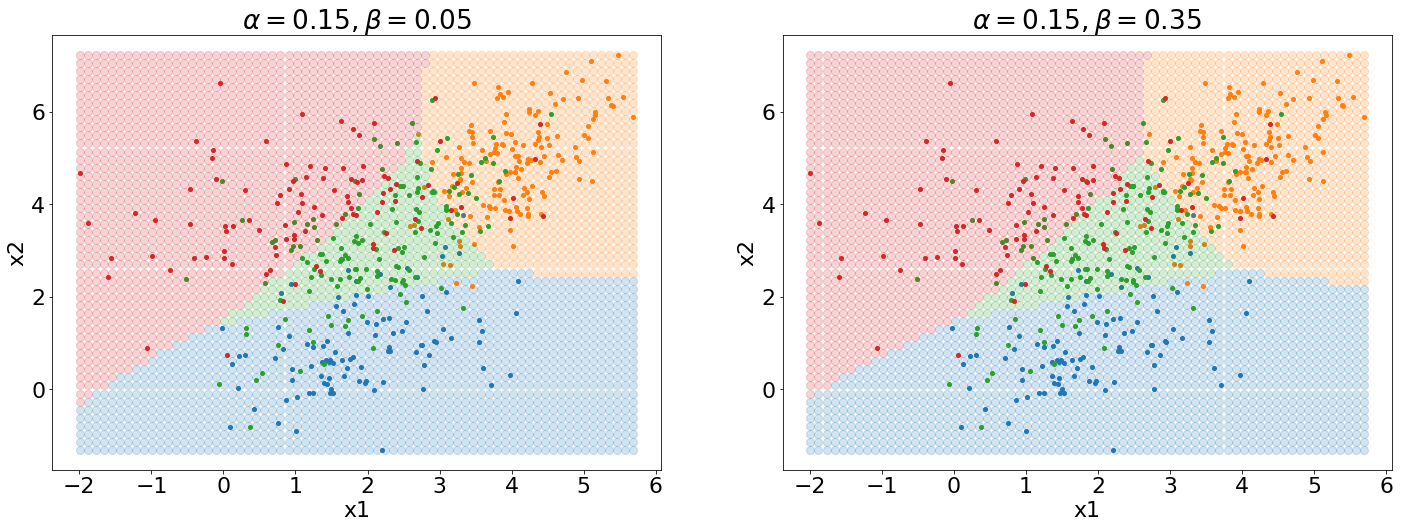

In [75]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 8)

canvases = [ax[0], ax[1]]

for i in range(2):
    canvas = canvases[i]
    params = parameters[i]
    class_map = maps[i]
    draw_map(class_map, canvas, data_size=4)
    canvas.set_title('$\\alpha={alpha}, \\beta={beta}$'.format(**params))
    canvas.set_xlabel('x1')
    canvas.set_ylabel('x2')

plt.show();